In [1]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import konlpy

%matplotlib inline

# 1. 데이터 로드 및 분석

In [27]:
path_to_file = os.getenv('HOME')+'/aiffel/AIFFEL_quest_rs/GoingDeeper/Deep0102/data/ratings_train.txt'

with open(path_to_file, "r") as f:
    train = f.read().splitlines()

print("Data Size:", len(train))

print("Example:")
for sen in train[0:100][::20]: print(">>", sen)

Data Size: 150001
Example:
>> id	document	label
>> 3989148	약탈자를 위한 변명, 이라. 저놈들은 착한놈들 절대 아닌걸요.	1
>> 4805788	이 영화가 왜 이렇게 저평가 받는지 모르겠다	1
>> 8317483	백봉기 언제나오나요?	1
>> 9801316	아햏햏 아햏햏 아햏햏.	1


AttributeError: 'list' object has no attribute 'head'

문장의 최단 길이: 8
문장의 최장 길이: 168
문장의 평균 길이: 45


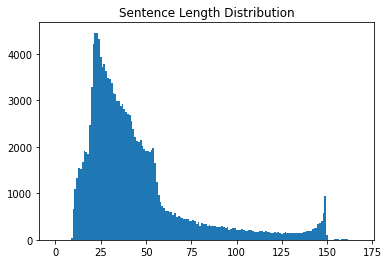

In [3]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train))

sentence_length = np.zeros((max_len), dtype=int)

for sen in train:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

Data Size: 150001
문장의 최단 길이: 8
문장의 최장 길이: 168
문장의 평균 길이: 45


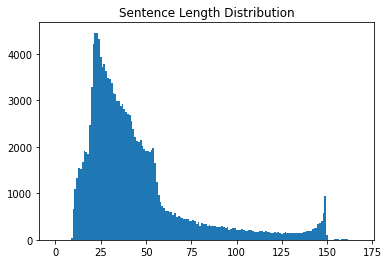

In [4]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(train))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

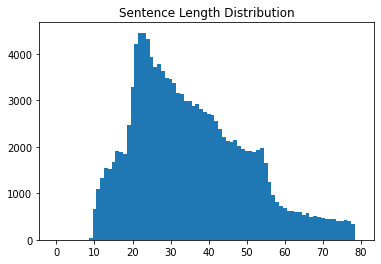

In [5]:
max_len = 80
min_len = 0

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

# 2. SentencePiece 모델 학습

In [6]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [7]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 368587 May  9 03:26 korean_spm.model
-rw-r--r-- 1 root root 137978 May  9 03:26 korean_spm.vocab


In [8]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[2762, 14, 382, 25, 2554, 14, 155, 26, 6]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


# 3. 토크나이저

In [9]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [10]:
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus)

In [11]:
print("예시 문장:", filtered_corpus[0])
print("토크나이즈된 시퀀스:", tensor[0])
print("디코딩된 문장:", s.DecodeIds([int(i) for i in tensor[0] if i != 0]))

예시 문장: 9442624	쓰레기.. 다들연기못함..	0
토크나이즈된 시퀀스: [   7 1675 1753  101    8 2319  381  469   87    8    5    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
디코딩된 문장: 9442624 쓰레기.. 다들연기못함.. 0


# 4. 구현된 토크나이저를 적용해서 네이버 영화리뷰 감정 분석 모델 재학습

In [12]:
train_path = os.getenv('HOME') + '/aiffel/AIFFEL_quest_rs/GoingDeeper/Deep0102/data/ratings_train.txt'
test_path = os.getenv('HOME') + '/aiffel/AIFFEL_quest_rs/GoingDeeper/Deep0102/data/ratings_test.txt'

In [13]:
import pandas as pd

# Load datasets
train_df = pd.read_csv(train_path, sep='\t').dropna()
test_df = pd.read_csv(test_path, sep='\t').dropna()

# Extract texts and labels
train_sentences = train_df['document'].astype(str).tolist()
train_labels = train_df['label'].astype(int).tolist()

test_sentences = test_df['document'].astype(str).tolist()
test_labels = test_df['label'].astype(int).tolist()

# Optional: 문장 길이 제한
max_len = 110
train_data = [(s, l) for s, l in zip(train_sentences, train_labels) if len(s) < max_len]
test_data = [(s, l) for s, l in zip(test_sentences, test_labels) if len(s) < max_len]

train_sentences, train_labels = zip(*train_data)
test_sentences, test_labels = zip(*test_data)


In [14]:
# 이미 학습된 모델 사용
import sentencepiece as spm

sp = spm.SentencePieceProcessor()
sp.Load("korean_spm.model")  # 사전 학습된 모델 경로

# 토크나이징 함수
def tokenize_with_sp(sp, corpus):
    tensor = [sp.EncodeAsIds(sen) for sen in corpus]
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor

X_train = tokenize_with_sp(sp, train_sentences)
X_test = tokenize_with_sp(sp, test_sentences)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

vocab_size = len(sp)  # SentencePiece vocab size


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(vocab_size, 128),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1024000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,073,473
Trainable params: 1,073,473
Non-trainable params: 0
_________________________________________________________________


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 모델 저장 경로
checkpoint_path = './best_sentiment_model.h5'

early_stop = EarlyStopping(
    monitor='val_loss',     # 검증 손실 기준
    patience=5,             # 3 epoch 이상 향상 없으면 중단
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, checkpoint]

In [22]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
#    callbacks=callbacks
)


Epoch 1/20
1786/1786 [==============================] - 11s 6ms/step - loss: 0.6932 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.5003
Epoch 2/20
1786/1786 [==============================] - 11s 6ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6931 - val_accuracy: 0.5003
Epoch 3/20
1786/1786 [==============================] - 11s 6ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.5003
Epoch 4/20
1786/1786 [==============================] - 11s 6ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.5003
Epoch 5/20
1786/1786 [==============================] - 11s 6ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.5003
Epoch 6/20
1786/1786 [==============================] - 11s 6ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5003
Epoch 7/20
1786/1786 [==============================] - 11s 6ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_ac

In [23]:
# 학습 후 가장 좋은 모델 불러오기
from tensorflow.keras.models import load_model

best_model = load_model(checkpoint_path)

loss, acc = best_model.evaluate(X_test, y_test)
print("Best Model Test Accuracy: {:.2f}%".format(acc * 100))


1487/1487 [==============================] - 4s 3ms/step - loss: 0.6931 - accuracy: 0.5067
Best Model Test Accuracy: 50.67%


# 5. KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

- Mecab

In [19]:
from konlpy.tag import Mecab
mecab = Mecab()

def mecab_tokenize(corpus):
    tokenized_corpus = []

    for sentence in corpus:
        tokens = mecab.morphs(sentence)  # 문장을 형태소 단위로 토큰화
        tokenized_corpus.append(tokens)

    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token="<OOV>")
    tokenizer.fit_on_texts(tokenized_corpus)

    tensor = tokenizer.texts_to_sequences(tokenized_corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

tensor, tokenizer = mecab_tokenize(filtered_corpus)


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ratings_train.txt 로딩
train_data = pd.read_table(path_to_file)  # path_to_file: ratings_train.txt

# Null 제거
train_data = train_data.dropna()

# 텍스트와 레이블 추출
texts = train_data['document'].astype(str).tolist()
labels = train_data['label'].tolist()

# Mecab 기반 토큰화
tensor, tokenizer = mecab_tokenize(texts)

# 훈련/검증 분리
x_train, x_val, y_train, y_val = train_test_split(tensor, labels, test_size=0.2, random_state=42, shuffle=True)


MeCab Vocab Size: 177230


In [ ]:
vocab_size = len(tokenizer.word_index) + 1

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 128),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# EarlyStopping & ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
mc = ModelCheckpoint('best_model_mecab.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=20,
                    batch_size=64,
                    callbacks=[es, mc])


- kkma

[[   7 1675 1753  101    8 2319  381  469   87    8    5    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   7 1810 1267   35 6511    6 4407  684 5151    6    3    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  28 1507 2202 2928 2576  115  102   22 3638  354   30  148  462 2155
     8  221  155  110 7664    8    3    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


- Okt